In [2]:
import pandas as pd
import pickle
import numpy as np
import datetime as dt
import nltk, string
import matplotlib.pyplot as plt
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from textblob import Word
from itertools import combinations, product
import random
import webbrowser

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### Loading required files and tables

In [ ]:
studies = pd.read_csv("Data/Studies.csv",index_col=0)
print(studies.shape)

In [4]:
#Key word similarity matrix
keyword_sim = pickle.load(open("Output/sim_mat_keyword_tfidf.pkl","rb"))

#Detailed desc similarity matrix
detailed_desc_sim = pickle.load(open("Output/sim_mat_d_desc_tfidf.pkl","rb"))

#Official title similarity matrix
official_tit_sim = pickle.load(open("Output/sim_mat_off_t_tfidf.pkl","rb"))

In [5]:
year_list = list(range(2014,2019))

In [6]:
for year in year_list:
    print(year, keyword_sim[year].shape, detailed_desc_sim[year].shape, official_tit_sim[year].shape)

2014 (709, 709) (709, 709) (709, 709)
2015 (963, 963) (963, 963) (963, 963)
2016 (1643, 1643) (1643, 1643) (1643, 1643)
2017 (4750, 4750) (4750, 4750) (4750, 4750)
2018 (3419, 3419) (3419, 3419) (3419, 3419)


### Guaging percentage null TFIDF vectors by year and method

In [6]:
keyword_sim_new = keyword_sim.copy()

In [7]:
null_keyword_vecs_by_year = {year:[] for year in year_list}

In [8]:
for year in year_list:
    for col in keyword_sim_new[year].columns:
        if keyword_sim_new[year][col][col]==0.0:
            null_keyword_vecs_by_year[year].append(col)

In [9]:
[(len(elem), len(elem)/keyword_sim_new[key].shape[0]) for key,elem in null_keyword_vecs_by_year.items()]

[(326, 0.459802538787024),
 (510, 0.5295950155763239),
 (1046, 0.6366402921485088),
 (3351, 0.7054736842105264),
 (2501, 0.7315004387247733)]

In [10]:
official_tit_sim_new = official_tit_sim.copy()

In [11]:
null_official_tit_vecs_by_year = {year:[] for year in year_list}

In [12]:
for year in year_list:
    for col in official_tit_sim_new[year].columns:
        if official_tit_sim_new[year][col][col]==0.0:
            null_official_tit_vecs_by_year[year].append(col)

In [13]:
[(len(elem),len(elem)/official_tit_sim_new[key].shape[0]) for key,elem in null_official_tit_vecs_by_year.items()]

[(49, 0.0691114245416079),
 (68, 0.07061266874350987),
 (168, 0.10225197808886184),
 (566, 0.1191578947368421),
 (370, 0.10821877742029833)]

In [14]:
detailed_desc_sim_new = detailed_desc_sim.copy()

In [15]:
null_detailed_desc_vecs_by_year = {year:[] for year in year_list}

In [16]:
for year in year_list:
    for col in detailed_desc_sim_new[year].columns:
        if detailed_desc_sim_new[year][col][col]==0.0:
            null_detailed_desc_vecs_by_year[year].append(col)

In [17]:
[(len(elem), len(elem)/detailed_desc_sim_new[key].shape[0]) for key,elem in null_detailed_desc_vecs_by_year.items()]

[(234, 0.3300423131170663),
 (341, 0.3541017653167186),
 (603, 0.3670115642118077),
 (1776, 0.3738947368421053),
 (1307, 0.38227551915764846)]

### Replacing similarities arising from null TFIDF vectors from 0.0 to NaN

In [18]:
for year in year_list:
    keyword_sim_new[year][null_keyword_vecs_by_year[year]] = np.NaN
    keyword_sim_new[year] = keyword_sim_new[year].T
    keyword_sim_new[year][null_keyword_vecs_by_year[year]] = np.NaN
    keyword_sim_new[year]  = keyword_sim_new[year].T

In [19]:
for year in year_list:
    official_tit_sim_new[year][null_official_tit_vecs_by_year[year]] = np.NaN
    official_tit_sim_new[year] = official_tit_sim_new[year].T
    official_tit_sim_new[year][null_official_tit_vecs_by_year[year]] = np.NaN
    official_tit_sim_new[year]  = official_tit_sim_new[year].T

In [20]:
for year in year_list:
    detailed_desc_sim_new[year][null_detailed_desc_vecs_by_year[year]] = np.NaN
    detailed_desc_sim_new[year] = detailed_desc_sim_new[year].T
    detailed_desc_sim_new[year][null_detailed_desc_vecs_by_year[year]] = np.NaN
    detailed_desc_sim_new[year]  = detailed_desc_sim_new[year].T

### Subtracting similarity matrices element-wise for all pairwise combinations

In [24]:
sim_mat_list = ['keyword_sim_new',
                'official_tit_sim_new',
                'detailed_desc_sim_new']
sim_mat_combs = {i:elem for i,elem in enumerate(combinations(sim_mat_list,
                                                             2))}

In [25]:
sim_mat_combs

{0: ('keyword_sim_new', 'official_tit_sim_new'),
 1: ('keyword_sim_new', 'detailed_desc_sim_new'),
 2: ('official_tit_sim_new', 'detailed_desc_sim_new')}

In [26]:
sim_mat_diffs = {}
for key,val in sim_mat_combs.items():
    sim_mat_diffs[key] = {year:abs(eval(val[0])[year]- eval(val[1])[year]) \
                          for year in year_list}

### Defining helper functions

In [27]:
def get_top_cols(row,threshold):
    col_names = list(row[row>threshold].index)
    return col_names

In [28]:
def get_max_diff_pairs(matrix, threshold):
    temp_arr = matrix[(matrix>threshold).any(1)]
    max_diff_series = pd.Series(data=temp_arr.apply(lambda x: get_top_cols(x,
                                                                           threshold),
                                                    axis=1),
                                 index=temp_arr.index)
    return max_diff_series

In [34]:
def get_tuples_and_dedup(x):
    x['tuples'] = [elem for elem in product(x['nct_id'],x[0])]
    return x

In [35]:
def get_max_diff_sample(series, 
                        frac_1,
                        frac_2,
                        random_state=84):
    
    series = series.rename_axis('nct_id').reset_index()
    series = series.groupby('nct_id').apply(lambda x: x[0].tolist()).apply(lambda x: \
                                                                    list(set([elem for ent in x for elem in ent])))
    rs = np.random.RandomState(random_state)
    idx_list = rs.choice(list(series.index),
                          size=int(series.shape[0]*frac_1),
                          replace=False)
    
    series = series.rename_axis('nct_id').reset_index()
    series = series[series['nct_id'].isin(idx_list)]
    series['nct_id'] = series['nct_id'].apply(lambda x: [x])
    series = series.apply(get_tuples_and_dedup,
                          axis=1)
    tup_list = list(set([tuple(sorted(elem)) for ent in series['tuples'].tolist() for elem in ent]))
    tup_list_idxs = np.array([i for i,elem in enumerate(tup_list)])
    chosen_idxs = list(rs.choice(tup_list_idxs,
                                  size=int(len(tup_list_idxs)*frac_2),
                                  replace=False))
    
    tup_list = list(np.array(tup_list)[chosen_idxs])
    tup_list = pd.DataFrame(data=[list(elem) for elem in tup_list],
                            columns=['nct_id_1','nct_id_2'])
    
    return tup_list

### identifying NCT ID pairs with max differences

In [47]:
temp_series = get_max_diff_pairs(matrix=sim_mat_diffs[2][2017],
                                 threshold=0.9)
print(temp_series.shape)

(1003,)


In [29]:
%%time

max_diff_by_sim_mat_diffs = {}
for key,val in sim_mat_diffs.items():
    max_diff_by_sim_mat_diffs[key] = {year:get_max_diff_pairs(matrix=sim_mat_diffs[key][year],
                                                              threshold=0.9) for year,val_2 in val.items()}

CPU times: user 5.06 s, sys: 280 ms, total: 5.34 s
Wall time: 5.41 s


In [31]:
for key,val in sim_mat_diffs.items():
    print(key,len(val),[val[elem].shape for elem in val])

0 5 [(709, 709), (963, 963), (1643, 1643), (4750, 4750), (3419, 3419)]
1 5 [(709, 709), (963, 963), (1643, 1643), (4750, 4750), (3419, 3419)]
2 5 [(709, 709), (963, 963), (1643, 1643), (4750, 4750), (3419, 3419)]


### estimating fraction of high difference IDs over all IDs (per year)

In [32]:
for key,val in max_diff_by_sim_mat_diffs.items():
    print("Difference Basis:", sim_mat_combs[key])
    for year,val_2 in max_diff_by_sim_mat_diffs[key].items():
        print(year,':',val_2.shape[0]/sim_mat_diffs[key][year].shape[0])
    print("")


Difference Basis: ('keyword_sim_new', 'official_tit_sim_new')
2014 : 0.14809590973201692
2015 : 0.17964693665628245
2016 : 0.1898965307364577
2017 : 0.20757894736842106
2018 : 0.16554548113483475

Difference Basis: ('keyword_sim_new', 'detailed_desc_sim_new')
2014 : 0.06488011283497884
2015 : 0.06334371754932502
2016 : 0.05964698721850274
2017 : 0.10610526315789473
2018 : 0.09271716876279613

Difference Basis: ('official_tit_sim_new', 'detailed_desc_sim_new')
2014 : 0.07334273624823695
2015 : 0.07268951194184839
2016 : 0.12720632988435787
2017 : 0.2111578947368421
2018 : 0.16964024568587308



### sampling high diff IDs (per year)

In [43]:
sum_mat_dims = sum([sim_mat_diffs[0][year].shape[0] for year in year_list])
sum_mat_dims

11484

In [44]:
frac_2_by_year = {year:1-2*round(sim_mat_diffs[0][year].shape[0]/sum_mat_dims,3) for year in year_list}

In [45]:
frac_2_by_year

{2014: 0.876, 2015: 0.832, 2016: 0.714, 2017: 0.17200000000000004, 2018: 0.404}

In [46]:
tup_list_by_year = {year:get_max_diff_sample(series=pd.concat(objs=[max_diff_by_sim_mat_diffs[key][year] \
                                                                    for key in max_diff_by_sim_mat_diffs],
                                                              axis=0),
                                             frac_1=0.5,
                                             frac_2=frac_2_by_year[year]) for year in year_list}

In [47]:
[val.shape for key,val in tup_list_by_year.items()]

[(128, 2), (200, 2), (475, 2), (1381, 2), (1468, 2)]

### generating feature matrices (from TF-iDF similarities) based on sampled high diff IDs (per year)

In [49]:
feat_mat_by_year = {year:pd.DataFrame([[keyword_sim_new[year][elem_1][elem_2],
                                        official_tit_sim_new[year][elem_1][elem_2],
                                        detailed_desc_sim_new[year][elem_1][elem_2], elem_1, elem_2] for elem_1,elem_2 in zip(tup_list_by_year[year]['nct_id_1'].tolist(), 
                                                                tup_list_by_year[year]['nct_id_2'].tolist())],
                                      columns=['_'.join(elem.split('_')[:-2])\
                                               for elem in sim_mat_list]+['nct_id_1',
                                                                          'nct_id_2'])
                                       for year in year_list}    

for year in year_list:
    feat_mat_by_year[year].index = [elem_1+'_'+elem_2 for elem_1,elem_2 in zip(feat_mat_by_year[year]['nct_id_1'].tolist(),
                                                                              feat_mat_by_year[year]['nct_id_2'].tolist())]
    

In [50]:
feat_mat_by_year_wo_na = {year:feat_mat_by_year[year].dropna() for year in year_list}

In [51]:
for year in year_list:
    print(year)
    print(feat_mat_by_year[year].shape)
    print(feat_mat_by_year_wo_na[year].shape)
    print("")

2014
(128, 5)
(76, 5)

2015
(200, 5)
(110, 5)

2016
(475, 5)
(198, 5)

2017
(1381, 5)
(472, 5)

2018
(1468, 5)
(469, 5)



In [52]:
for year in year_list:
    tup_list_by_year[year].index = [elem_1+'_'+elem_2 for elem_1,elem_2 in zip(tup_list_by_year[year]['nct_id_1'].tolist(),
                                                                               tup_list_by_year[year]['nct_id_2'].tolist())]

In [53]:
common_pairs_by_year = {year:\
                        list(set(feat_mat_by_year_wo_na[year].index).intersection(set(tup_list_by_year[year].index))) \
                        for year in year_list}

In [54]:
for year in year_list:
    feat_mat_by_year_wo_na[year] = feat_mat_by_year_wo_na[year].loc[common_pairs_by_year[year]]
    tup_list_by_year[year]  =tup_list_by_year[year].loc[common_pairs_by_year[year]]

In [55]:
for year in year_list:
    print(feat_mat_by_year_wo_na[year].shape,tup_list_by_year[year].shape)

(76, 5) (76, 2)
(110, 5) (110, 2)
(198, 5) (198, 2)
(472, 5) (472, 2)
(469, 5) (469, 2)


In [67]:
for key in tup_list_by_year:
    file_name_1 = 'Data/feat_mat_by_year_'+str(key)+'.csv'
    file_name_2 = 'Data/tup_list_by_year_'+str(key)+'.csv'
    feat_mat_by_year_wo_na[key].to_csv(file_name_1)
    tup_list_by_year[key].to_csv(file_name_2)

### Plotting Correlation Matrices for Feature Matrices (per year)

In [69]:
#overall correlation plot
def plot_corr(data,col_names,figsize):
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(np.corrcoef(data[col_names].T), 
                     interpolation='nearest')
    fig.colorbar(cax,fraction=0.046, pad=0.04)
    ax.set_xticks(range(len(col_names)))
    ax.set_yticks(range(len(col_names)))
    ax.set_xticklabels(col_names,rotation=90)
    ax.set_yticklabels(col_names)
    plt.show()

In [70]:
col_names = ['_'.join(elem.split('_')[:-2]) for elem in sim_mat_list]
col_names

['keyword', 'official_tit', 'detailed_desc']

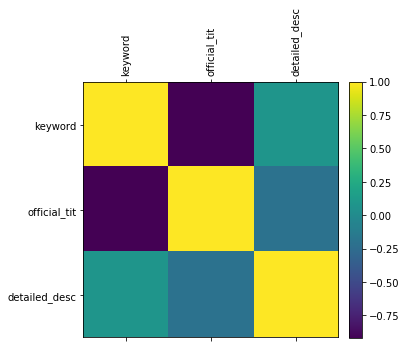

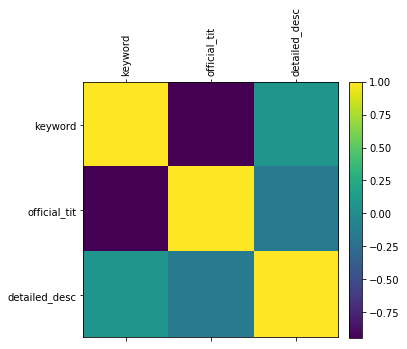

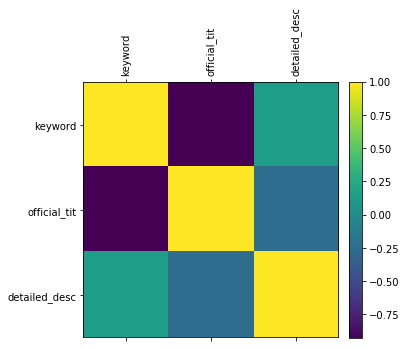

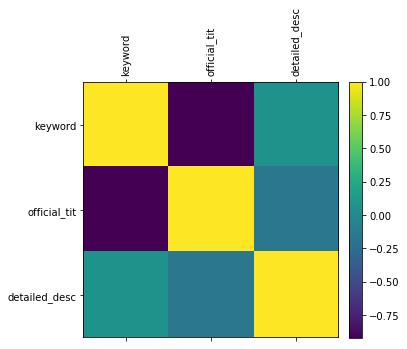

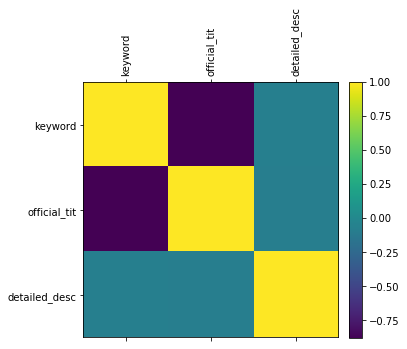

In [71]:
for year in year_list:
    plot_corr(feat_mat_by_year_wo_na[year],col_names,figsize=(5,5))

### Manual similarity validation

In [ ]:
for idx in tup_list_by_year[2014].index[:70]:
    print()
    for elem in idx.split('_'):
        print(elem)
        webbrowser.open('https://clinicaltrials.gov/ct2/show/record/'+ elem)
    curr_status = input("Please enter current NCT ID Pair Review Status:").lower()
    if (curr_status=='done') or (curr_status=='next'):
        continue

In [ ]:
for idx in tup_list_by_year[2015].index[:70]:
    print()
    for elem in idx.split('_'):
        print(elem)
        webbrowser.open('https://clinicaltrials.gov/ct2/show/record/'+ elem)
    curr_status = input("Please enter current NCT ID Pair Review Status:").lower()
    if (curr_status=='done') or (curr_status=='next'):
        continue

In [ ]:
for idx in tup_list_by_year[2016].index[:70]:
    print()
    for elem in idx.split('_'):
        print(elem)
        webbrowser.open('https://clinicaltrials.gov/ct2/show/record/'+ elem)
    curr_status = input("Please enter current NCT ID Pair Review Status:").lower()
    if (curr_status=='done') or (curr_status=='next'):
        continue

### Linear regression across all years

In [168]:
# nct_ids_by_year_with_pos = pickle.load(open("../ids_by_year_fda_reg_with_pos.pkl","rb"))

In [170]:
for year in range(2014,2019):
    print(year,':',len(nct_ids_by_year_with_pos[year]))

2014 : 709
2015 : 963
2016 : 1643
2017 : 4750
2018 : 3419


### vertically stacking manual validation scores across all years

In [173]:
for year in year_list:
    tup_list_by_year_filled[year].reset_index(drop=True,
                                              inplace=True)

In [180]:
tup_list_by_year_filled_all = pd.concat(objs=[tup_list_by_year_filled[year] for year in year_list],
                                        axis=0).reset_index(drop=True)
print(tup_list_by_year_filled_all.shape)

(350, 3)


In [182]:
tup_list_by_year_filled_all_rev = tup_list_by_year_filled_all.copy()
tup_list_by_year_filled_all_rev.columns = ['nct_id_2','nct_id_1','manual_score']

tup_list_by_year_filled_concat = pd.concat(objs=[tup_list_by_year_filled_all,tup_list_by_year_filled_all_rev],
                                           axis=0)

tup_list_by_year_filled_avg = tup_list_by_year_filled_concat.groupby(['nct_id_1','nct_id_2'])['manual_score']\
.mean().reset_index()

print(tup_list_by_year_filled_concat.shape, tup_list_by_year_filled_avg.shape)

(700, 3) (700, 3)


### generating manual validation matrices for each year

In [186]:
def manualValidationMatrix(labels, index):
    shape = (len(index),len(index))
    validationMatrix = -np.ones(shape)
    
    for _, row in labels.iterrows():
        try:
            validationMatrix[index[row['nct_id_1']]][index[row['nct_id_2']]] = row['manual_score']
        except:
            None
            
    return validationMatrix

In [187]:
%%time

validationMatrix_2014 = manualValidationMatrix(tup_list_by_year_filled_avg, 
                                               nct_ids_by_year_with_pos[2014])
validationMatrix_2015 = manualValidationMatrix(tup_list_by_year_filled_avg, 
                                               nct_ids_by_year_with_pos[2015])
validationMatrix_2016 = manualValidationMatrix(tup_list_by_year_filled_avg, 
                                               nct_ids_by_year_with_pos[2016])
validationMatrix_2017 = manualValidationMatrix(tup_list_by_year_filled_avg, 
                                               nct_ids_by_year_with_pos[2017])
validationMatrix_2018 = manualValidationMatrix(tup_list_by_year_filled_avg, 
                                               nct_ids_by_year_with_pos[2018])

print(validationMatrix_2014.shape, 
      validationMatrix_2015.shape, 
      validationMatrix_2016.shape, 
      validationMatrix_2017.shape, 
      validationMatrix_2018.shape)

(709, 709) (963, 963) (1643, 1643) (4750, 4750) (3419, 3419)
CPU times: user 397 ms, sys: 144 ms, total: 540 ms
Wall time: 673 ms


### stack and ravel validation matrices

In [192]:
validationMatrix_ravel = np.hstack([np.ravel(validationMatrix_2014),
                                    np.ravel(validationMatrix_2015),
                                    np.ravel(validationMatrix_2016),
                                    np.ravel(validationMatrix_2017),
                                    np.ravel(validationMatrix_2018)])

validated_indices = np.where(validationMatrix_ravel > -1)

print(validationMatrix_ravel[validated_indices][:10], len(validationMatrix_ravel[validated_indices]))

[0.  0.8 0.2 0.1 0.  0.2 0.2 0.  0.1 0.1] 700


In [200]:
def modelCovariatePrep(model, index_list):
    for year in range(2014,2019):
        if year == 2014:
            model_ravel = np.ravel(model[year])
        else:
            model_ravel = np.hstack([model_ravel,
                                     np.ravel(model[year])])

    return model_ravel, model_ravel[index_list]

In [201]:
%%time

pred_keyword, X_keyword = modelCovariatePrep(keyword_sim,
                                             validated_indices)

pred_off_title, X_off_title = modelCovariatePrep(official_tit_sim,
                                                 validated_indices)

pred_detailed_desc, X_detailed_desc = modelCovariatePrep(detailed_desc_sim,
                                                         validated_indices)

print(X_keyword.shape, X_off_title.shape, X_detailed_desc.shape)

(700,) (700,) (700,)
CPU times: user 880 ms, sys: 1.74 s, total: 2.62 s
Wall time: 3.13 s


### fit regression

In [206]:
X = np.vstack([X_keyword,
               X_off_title,
               X_detailed_desc
              ]).T

y = validationMatrix_ravel[validated_indices]

reg = LinearRegression(fit_intercept=False)
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [207]:
reg.coef_

array([0.13160499, 0.1260861 , 0.2228721 ])

### finalize similarity matrices

In [211]:
X_pred = np.vstack([pred_keyword,
                    pred_off_title,
                    pred_detailed_desc
                  ]).T
print(X_pred.shape)

(38381560, 3)


In [212]:
def makePredictions(reg, X, index):
    y_pred = reg.predict(X)
    
    # Find position in ravelled y_pred where each years matrix starts
    indices_2014 = [0,len(index[2014])**2]
    indices_2015 = [indices_2014[1], indices_2014[1] + len(index[2015])**2]
    indices_2016 = [indices_2015[1], indices_2015[1] + len(index[2016])**2]
    indices_2017 = [indices_2016[1], indices_2016[1] + len(index[2017])**2]
    indices_2018 = [indices_2017[1], indices_2017[1] + len(index[2018])**2]
    
    # Extract year portion of ravelled y_pred. Reshape and clip to [0,1]
    y_pred_2014 = np.clip(np.reshape(y_pred[indices_2014[0]:indices_2014[1]],
                                     (len(index[2014]),len(index[2014]))),
                          0,
                          1)
    y_pred_2015 = np.clip(np.reshape(y_pred[indices_2015[0]:indices_2015[1]],
                                     (len(index[2015]),len(index[2015]))),
                          0,
                          1)
    y_pred_2016 = np.clip(np.reshape(y_pred[indices_2016[0]:indices_2016[1]],
                                     (len(index[2016]),len(index[2016]))),
                          0,
                          1)
    y_pred_2017 = np.clip(np.reshape(y_pred[indices_2017[0]:indices_2017[1]],
                                     (len(index[2017]),len(index[2017]))),
                          0,
                          1)
    y_pred_2018 = np.clip(np.reshape(y_pred[indices_2018[0]:indices_2018[1]],
                                     (len(index[2018]),len(index[2018]))),
                          0,
                          1)
    
    return y_pred_2014, y_pred_2015, y_pred_2016, y_pred_2017, y_pred_2018

In [213]:
%%time

sim_2014, sim_2015, sim_2016, sim_2017, sim_2018 = makePredictions(reg, 
                                                                   X_pred, 
                                                                   nct_ids_by_year_with_pos)

CPU times: user 922 ms, sys: 1.01 s, total: 1.93 s
Wall time: 2.07 s


In [214]:
print(sim_2014.shape, 
      sim_2015.shape, 
      sim_2016.shape, 
      sim_2017.shape, 
      sim_2018.shape)

(709, 709) (963, 963) (1643, 1643) (4750, 4750) (3419, 3419)


In [220]:
# np.save('Output/sim_2014.npy',sim_2014)
# np.save('Output/sim_2015.npy',sim_2015)
# np.save('Output/sim_2016.npy',sim_2016)
# np.save('Output/sim_2017.npy',sim_2017)
# np.save('Output/sim_2018.npy',sim_2018)